In [ ]:
! pip install -U statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [ ]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# color maps
from matplotlib import cm

# time series
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from scipy.stats import chi2_contingency
from scipy.spatial import distance

# chi-square test
import scipy
from scipy.stats import pearsonr

## Prepare

In [ ]:
# read file
url_combine_new = 'https://raw.githubusercontent.com/huahuang95/Capstone-Project/main/Datasets/new%20combine.csv?token=ARFHYYCNVJZLFVLFVVN3XBTA65FEQ'
combine_new = pd.read_csv(url_combine_new)
combine_new.head()

,Unnamed: 0,date_class,ReportDate,AssetClass,Flow_i,FlowPCT_i,AssetsEnd_i,PortfolioChangePct_i,Flow_r,FlowPCT_r,AssetsEnd_r,PortfolioChangePct_r,Flow_e,FlowPCT_e,AssetsEnd_e,PortfolioChangePct_e,ClosePct_Nasdaq,VolumePct_Nasdaq,ClosePct_Dow,VolumePct_Dow,ClosePct_Russell,VolumePct_Russell,ClosePct_SP500,VolumePct_SP500,CpiPct
0,0,2/1/2017 12:00:00 AMCommodities/Materials-Nort...,2/1/2017,Commodities/Materials-North America-USA-North ...,380.126769,4.4676,8787.631717,-1.1853,25.681524,8.0046,344.521230,-0.6207,378.578706,4.5064,8679.056347,-1.1938,-0.242029,13.449833,-0.884819,14.622287,-1.534244,1.835404,-0.818841,1.835404,0.314612
1,1,2/1/2017 12:00:00 AMConsumer Goods-North Ameri...,2/1/2017,Consumer Goods-North America-USA-North America...,332.526792,1.1479,28973.613060,-1.1231,-3.951259,-1.1736,329.044261,-1.0916,332.526792,1.1479,28973.613060,-1.1231,-0.242029,13.449833,-0.884819,14.622287,-1.534244,1.835404,-0.818841,1.835404,0.314612
2,2,2/1/2017 12:00:00 AMEnergy-North America-USA-N...,2/1/2017,Energy-North America-USA-North America-Equity,217.857886,0.3460,62136.008340,-1.6441,73.933969,0.2713,27246.540020,-0.2297,186.031374,0.3782,48446.700080,-1.8855,-0.242029,13.449833,-0.884819,14.622287,-1.534244,1.835404,-0.818841,1.835404,0.314612
3,3,2/1/2017 12:00:00 AMFinancials-North America-U...,2/1/2017,Financials-North America-USA-North America-Equity,999.104807,1.4776,68011.826210,-0.8896,15.229132,0.2027,7463.581982,-0.7166,968.885223,1.5139,64378.816730,-0.9202,-0.242029,13.449833,-0.884819,14.622287,-1.534244,1.835404,-0.818841,1.835404,0.314612
4,4,2/1/2017 12:00:00 AMHealth Care/Biotech-North ...,2/1/2017,Health Care/Biotech-North America-USA-North Am...,399.074410,1.0228,40317.775600,2.3099,-81.493857,-0.6587,12575.155820,2.2876,410.686628,1.1532,36846.852740,2.3119,-0.242029,13.449833,-0.884819,14.622287,-1.534244,1.835404,-0.818841,1.835404,0.314612


In [ ]:
def preprocessing_new(df):
  # extract columns
  df = df[["AssetClass","ReportDate", "AssetsEnd_i","AssetsEnd_e","FlowPCT_i","PortfolioChangePct_i", "FlowPCT_e","PortfolioChangePct_e",'ClosePct_Nasdaq',	'VolumePct_Nasdaq',	'ClosePct_Dow',	'VolumePct_Dow',	'ClosePct_Russell',	'VolumePct_Russell',	'ClosePct_SP500',	'VolumePct_SP500', 'CpiPct']]
  df.rename(columns={"FlowPCT_i": "FlowPct_i", "FlowPCT_e": "FlowPct_e"}, inplace=True)
  
  # convert ReportDate to datetime 
  df['ReportDate'] = pd.to_datetime(df["ReportDate"])
  
  # extract year
  df['year'] = df['ReportDate'].dt.year

  # set ReportDate as index
  df.sort_values("ReportDate", inplace=True)
  df.set_index('ReportDate', inplace=True)
  return df

In [ ]:
# trim AssetClass names
combine_new['AssetClass'] = combine_new['AssetClass'].str.replace('-North America-USA-North America-Equity', '')
combine_new = preprocessing_new(combine_new)

grouped = combine_new.groupby(combine_new['AssetClass'])
com = grouped.get_group('Commodities/Materials')
con = grouped.get_group('Consumer Goods')
ene = grouped.get_group('Energy')
fin = grouped.get_group('Financials')
hea = grouped.get_group('Health Care/Biotech')
ind = grouped.get_group('Industrials')
lcb = grouped.get_group('Large Cap Blend')
lcg = grouped.get_group('Large Cap Growth')
lcv = grouped.get_group('Large Cap Value')
mcb = grouped.get_group('Mid Cap Blend')
mcg = grouped.get_group('Mid Cap Growth')
mcv = grouped.get_group('Mid Cap Value')
rea = grouped.get_group('Real Estate')
scb = grouped.get_group('Small Cap Blend')
scg = grouped.get_group('Small Cap Growth')
scv = grouped.get_group('Small Cap Value')
tec = grouped.get_group('Technology')
tel = grouped.get_group('Telecom')
uti = grouped.get_group('Utilities')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [ ]:
# winsorizing: replace outliers with the 1st and 99th percentile by year
def clipped_new(df):
  # FlowPct_i
  # loop over 2006 to 2017
  for i in range(2006, 2018):
    temp = df[df['year']==i]['FlowPct_i']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='FlowPct_i') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp]) 
  df1 = pd.DataFrame(append)
  
  # replace the original column with the winsorized one
  df.drop(columns='FlowPct_i', inplace=True)
  df = pd.concat([df, df1], axis=1)


  # repeat above steps
  # PortfolioChangePct_i
  for i in range(2006, 2018):
    temp = df[df['year']==i]['PortfolioChangePct_i']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='PortfolioChangePct_i') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='PortfolioChangePct_i', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # FlowPct_e
  for i in range(2006, 2018):
    temp = df[df['year']==i]['FlowPct_e']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='FlowPct_e') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='FlowPct_e', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # PortfolioChangePct_e
  for i in range(2006, 2018):
    temp = df[df['year']==i]['PortfolioChangePct_e']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='PortfolioChangePct_e') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='PortfolioChangePct_e', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # ClosePct_Nasdaq
  for i in range(2006, 2018):
    temp = df[df['year']==i]['ClosePct_Nasdaq']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='ClosePct_Nasdaq') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='ClosePct_Nasdaq', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # VolumePct_Nasdaq
  for i in range(2006, 2018):
    temp = df[df['year']==i]['VolumePct_Nasdaq']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='VolumePct_Nasdaq') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='VolumePct_Nasdaq', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # ClosePct_Dow
  for i in range(2006, 2018):
    temp = df[df['year']==i]['ClosePct_Dow']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='ClosePct_Dow') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='ClosePct_Dow', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # VolumePct_Dow
  for i in range(2006, 2018):
    temp = df[df['year']==i]['VolumePct_Dow']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='VolumePct_Dow') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='VolumePct_Dow', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # ClosePct_Russell
  for i in range(2006, 2018):
    temp = df[df['year']==i]['ClosePct_Russell']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='ClosePct_Russell') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='ClosePct_Russell', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # VolumePct_Russell
  for i in range(2006, 2018):
    temp = df[df['year']==i]['VolumePct_Russell']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='VolumePct_Russell') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='VolumePct_Russell', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # ClosePct_SP500
  for i in range(2006, 2018):
    temp = df[df['year']==i]['ClosePct_SP500']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='ClosePct_SP500') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='ClosePct_SP500', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # VolumePct_SP500
  for i in range(2006, 2018):
    temp = df[df['year']==i]['VolumePct_SP500']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='VolumePct_SP500') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='VolumePct_SP500', inplace=True)
  df = pd.concat([df, df1], axis=1)

  # CpiPct
  for i in range(2006, 2018):
    temp = df[df['year']==i]['CpiPct']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='CpiPct') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='CpiPct', inplace=True)
  df = pd.concat([df, df1], axis=1)

  #AssetsEnd_i
  for i in range(2006, 2018):
    temp = df[df['year']==i]['AssetsEnd_i']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='AssetsEnd_i') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='AssetsEnd_i', inplace=True)
  df = pd.concat([df, df1], axis=1)

  #AssetsEnd_e
  for i in range(2006, 2018):
    temp = df[df['year']==i]['AssetsEnd_e']
    temp.clip(lower=temp.quantile(0.01), upper=temp.quantile(0.99), inplace=True)
    if i == 2006:
      s = pd.Series([], name='AssetsEnd_e') 
      append = pd.concat([s, temp])
    else:
      append = pd.concat([append, temp])
  
  df1 = pd.DataFrame(append)
  df.drop(columns='AssetsEnd_e', inplace=True)
  df = pd.concat([df, df1], axis=1) 
  
  return df

In [ ]:
# save as dataframe with original names
com = clipped_new(com)
con = clipped_new(con)
ene = clipped_new(ene)
fin = clipped_new(fin)
hea = clipped_new(hea)
ind = clipped_new(ind)
lcb = clipped_new(lcb)
lcg = clipped_new(lcg)
lcv = clipped_new(lcv)
mcb = clipped_new(mcb)
mcg = clipped_new(mcg)
mcv = clipped_new(mcv)
rea = clipped_new(rea)
scb = clipped_new(scb)
scg = clipped_new(scg)
scv = clipped_new(scv)
tec = clipped_new(tec)
tel = clipped_new(tel)
uti = clipped_new(uti)

串流輸出內容已截斷至最後 5000 行。
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._clip_with_scalar(lower, upper, inplace=inplace)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:7358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._clip_with_scalar(lower, upper, inplace=inplace)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:7358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._clip_with_scalar(lower, upper, inp

In [ ]:
com.drop(['AssetClass','year'],axis=1,inplace=True)
con.drop(['AssetClass','year'],axis=1,inplace=True)
ene.drop(['AssetClass','year'],axis=1,inplace=True)
fin.drop(['AssetClass','year'],axis=1,inplace=True)
hea.drop(['AssetClass','year'],axis=1,inplace=True)
ind.drop(['AssetClass','year'],axis=1,inplace=True)
lcb.drop(['AssetClass','year'],axis=1,inplace=True)
lcg.drop(['AssetClass','year'],axis=1,inplace=True)
lcv.drop(['AssetClass','year'],axis=1,inplace=True)
mcb.drop(['AssetClass','year'],axis=1,inplace=True)
mcg.drop(['AssetClass','year'],axis=1,inplace=True)
mcv.drop(['AssetClass','year'],axis=1,inplace=True)
rea.drop(['AssetClass','year'],axis=1,inplace=True)
scb.drop(['AssetClass','year'],axis=1,inplace=True)
scg.drop(['AssetClass','year'],axis=1,inplace=True)
scv.drop(['AssetClass','year'],axis=1,inplace=True)
tec.drop(['AssetClass','year'],axis=1,inplace=True)
tel.drop(['AssetClass','year'],axis=1,inplace=True)
uti.drop(['AssetClass','year'],axis=1,inplace=True)

### Apply moving average (windows=4)

Use moving average(set windows=4, one month) to smooth the datasets and remove the volatility. 

In [ ]:
# add the AssetsEnd_e(t-1) and AssetsEnd_i(t-1) to the dataframe
def assets(df):
  df['AssetsEnd_e(t-1)'] = df['AssetsEnd_e'].shift(periods=1)
  df['AssetsEnd_i(t-1)'] = df['AssetsEnd_i'].shift(periods=1)
  return df

In [ ]:
# smooth time series(set windows=4 (a month))
def rolling_avg(df):
  df = df.rolling(window=4).mean().iloc[3:,:]
  return df

In [ ]:
com = rolling_avg(com)
con = rolling_avg(con)
ene = rolling_avg(ene)
fin = rolling_avg(fin)
hea = rolling_avg(hea)
ind = rolling_avg(ind)
lcb = rolling_avg(lcb)
lcg = rolling_avg(lcg)
lcv = rolling_avg(lcv)
mcb = rolling_avg(mcb)
mcg = rolling_avg(mcg)
mcv = rolling_avg(mcv)
rea = rolling_avg(rea)
scb = rolling_avg(scb)
scg = rolling_avg(scg)
scv = rolling_avg(scv)
tec = rolling_avg(tec)
tel = rolling_avg(tel)
uti = rolling_avg(uti)

In [ ]:
com = assets(com)
con = assets(con)
ene = assets(ene)
fin = assets(fin)
hea = assets(hea)
ind = assets(ind)
lcb = assets(lcb)
lcg = assets(lcg)
lcv = assets(lcv)
mcb = assets(mcb)
mcg = assets(mcg)
mcv = assets(mcv)
rea = assets(rea)
scb = assets(scb)
scg = assets(scg)
scv = assets(scv)
tec = assets(tec)
tel = assets(tel)
uti = assets(uti)

# Pilot dataset

To illustrate the complete LSTM workflow, as we did in VAR model, we will use energy sector as pilot dataset.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import operator

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from math import sqrt
from datetime import datetime
from datetime import timedelta

test_size = 52
time_step = 52

## ene, Energy

### P_e prediction

#### Data preparation

In [ ]:
df = ene.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,2.147875,2.147800,NaN,NaN
2006-02-01,1.284375,1.284150,2.391215,2.391059
2006-02-08,1.895750,1.895800,1.737250,1.737233
2006-02-15,1.808650,1.808750,0.293783,0.293918
2006-02-22,5.597316,5.601735,50.555569,50.565680
...,...,...,...,...
2017-01-04,0.661686,0.717311,1.313836,1.237450
2017-01-11,0.387201,0.348523,0.850608,0.636425
2017-01-18,0.285051,0.212098,0.301791,0.142801
2017-01-25,0.362851,0.308098,0.755720,0.581282


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

#### Define and fit model

LSTM expect the input data to be in a specific format, usually a 3D array, namely [samples, timesteps, features]. We start by creating data in 60 timesteps and converting it into an array. Next, we convert the data into a 3D array with X_train samples, 60 timesteps, and one feature at each step.

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=2, shuffle=False)

Epoch 1/100
10/10 - 2s - loss: 0.1661 - accuracy: 0.0021
Epoch 2/100
10/10 - 0s - loss: 0.0369 - accuracy: 0.0021
Epoch 3/100
10/10 - 0s - loss: 0.0401 - accuracy: 0.0021
Epoch 4/100
10/10 - 0s - loss: 0.0270 - accuracy: 0.0021
Epoch 5/100
10/10 - 0s - loss: 0.0248 - accuracy: 0.0021
Epoch 6/100
10/10 - 0s - loss: 0.0240 - accuracy: 0.0021
Epoch 7/100
10/10 - 0s - loss: 0.0241 - accuracy: 0.0021
Epoch 8/100
10/10 - 0s - loss: 0.0235 - accuracy: 0.0021
Epoch 9/100
10/10 - 0s - loss: 0.0238 - accuracy: 0.0021
Epoch 10/100
10/10 - 0s - loss: 0.0236 - accuracy: 0.0021
Epoch 11/100
10/10 - 0s - loss: 0.0235 - accuracy: 0.0021
Epoch 12/100
10/10 - 0s - loss: 0.0236 - accuracy: 0.0021
Epoch 13/100
10/10 - 0s - loss: 0.0234 - accuracy: 0.0021
Epoch 14/100
10/10 - 0s - loss: 0.0235 - accuracy: 0.0021
Epoch 15/100
10/10 - 0s - loss: 0.0234 - accuracy: 0.0021
Epoch 16/100
10/10 - 0s - loss: 0.0234 - accuracy: 0.0021
Epoch 17/100
10/10 - 0s - loss: 0.0234 - accuracy: 0.0021
Epoch 18/100
10/10 - 0s

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

# check length of predict
len(predict)

52

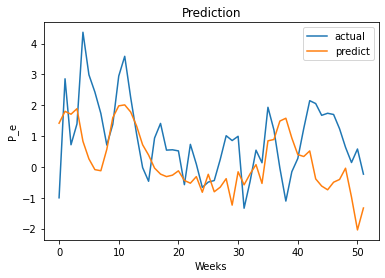

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.458


#### Convert to binary variable
Convert one-year prediction results to binary variable.

In [ ]:
type(predict)

numpy.ndarray

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.001601,1.418617
1,2.859874,1.803971
2,0.719559,1.710222
3,1.397110,1.890152
4,4.370230,0.831918


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.001601,1.418617,0,0
1,2.859874,1.803971,0,0
2,0.719559,1.710222,0,0
3,1.397110,1.890152,0,0
4,4.370230,0.831918,0,0


##### Define function - change_binary()

To better understand the directional patterns of the forecasts, we change actual and forecast values to binary numbers to detect direction. For example, if we set the threshold as 0.1 which means if the current value < last week's value - 0.1, then change the value to -1, indicating a decrease in returns; if the current value > last week's value + 0.1, then change the value to 1, indicating an increase in returns; otherwise change the value to 0.

In [ ]:
def change_binary(direc, threshold=0):
  for i in range(len(direc)-1):
    if direc.loc[:, 'Actual'].iloc[i+1] < (direc.loc[:, 'Actual'].iloc[i] - threshold):
      direc.loc[:, 'Actual_direc'].iloc[i+1] = -1
    elif direc.loc[:, 'Actual'].iloc[i+1] > (direc.loc[:, 'Actual'].iloc[i] + threshold):
      direc.loc[:, 'Actual_direc'].iloc[i+1] = 1
    else:
      direc.loc[:, 'Actual_direc'].iloc[i+1] = 0

  for i in range(len(direc)-1):
    if direc.loc[:, 'Forecast'].iloc[i+1] < (direc.loc[:, 'Forecast'].iloc[i] - threshold):
      direc.loc[:, 'Forecast_direc'].iloc[i+1] = -1
    elif direc.loc[:, 'Forecast'].iloc[i+1] > (direc.loc[:, 'Forecast'].iloc[i] + threshold):
      direc.loc[:, 'Forecast_direc'].iloc[i+1] = 1
    else:
      direc.loc[:, 'Forecast_direc'].iloc[i+1] = 0

In [ ]:
# def change_binary(direc, threshold=0):
#   for i in range(len(direc)-1):
#     if ((direc.loc[:, 'Actual'].iloc[i+1] - direc.loc[:, 'Actual'].iloc[i]) / direc.loc[:, 'Actual'].iloc[i]) < threshold:
#       direc.loc[:, 'Actual_direc'].iloc[i+1] = -1
#     elif ((direc.loc[:, 'Actual'].iloc[i+1] - direc.loc[:, 'Actual'].iloc[i]) / direc.loc[:, 'Actual'].iloc[i]) > threshold:
#       direc.loc[:, 'Actual_direc'].iloc[i+1] = 1
#     else:
#       direc.loc[:, 'Actual_direc'].iloc[i+1] = 0

#   for i in range(len(direc)-1):
#     if ((direc.loc[:, 'Forecast'].iloc[i+1] - direc.loc[:, 'Forecast'].iloc[i]) / direc.loc[:, 'Forecast'].iloc[i]) < threshold:
#       direc.loc[:, 'Forecast_direc'].iloc[i+1] = -1
#     elif ((direc.loc[:, 'Forecast'].iloc[i+1] - direc.loc[:, 'Forecast'].iloc[i]) / direc.loc[:, 'Forecast'].iloc[i]) > threshold:
#       direc.loc[:, 'Forecast_direc'].iloc[i+1] = 1
#     else:
#       direc.loc[:, 'Forecast_direc'].iloc[i+1] = 0

##### Define function - define_threshold()
Find the best-performing threshold.

In [ ]:
direc.describe()

,Actual,Forecast,Actual_direc,Forecast_direc
count,52.000000,52.000000,52.0,52.0
mean,0.895548,0.196029,0.0,0.0
std,1.220194,0.970882,0.0,0.0
min,-1.339793,-2.044026,0.0,0.0
25%,0.062218,-0.452987,0.0,0.0
50%,0.725882,-0.105944,0.0,0.0
75%,1.681102,0.857467,0.0,0.0
max,4.370230,2.013353,0.0,0.0


Consider the mean and standard deviation of PortfolioChangePct, we use `for` loop from 0.01 to 0.20 to find the best-performing threshold with the maximal accuracy score.

In [ ]:
def define_threshold(direc):
  thre_list = []
  acc_list = []
  for i in np.arange(0.01, 0.21, 0.01):
    t = float(round(i, 4))
    change_binary(direc, threshold=t)

    # check by accuracy score
    acc = round(accuracy_score(direc.loc[:, 'Actual_direc'], direc.loc[:, 'Forecast_direc']), 4)
    # create dictionary for later use
    # key
    thre_list.append(t)
    # value
    acc_list.append(acc)
    print(f'When threshold = {t}, accuracy score = {acc}')

  acc_dict = dict(zip(thre_list, acc_list))
  # set best_thre as global variable for later use
  global best_thre
  best_thre = max(acc_dict.items(), key=operator.itemgetter(1))[0]
  print(f'The best-performing threshold: {best_thre}')

In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.01, accuracy score = 0.6154
When threshold = 0.02, accuracy score = 0.5962
When threshold = 0.03, accuracy score = 0.5962
When threshold = 0.04, accuracy score = 0.5577
When threshold = 0.05, accuracy score = 0.5769
When threshold = 0.06, accuracy score = 0.5769
When threshold = 0.07, accuracy score = 0.5769
When threshold = 0.08, accuracy score = 0.5769
When threshold = 0.09, accuracy score = 0.5577
When threshold = 0.1, accuracy score = 0.5192
When threshold = 0.11, accuracy score = 0.5192
When threshold = 0.12, accuracy score = 0.5192
When threshold = 0.13, accuracy score = 0.5385
When threshold = 0.14, accuracy score = 0.5192
When threshold = 0.15, accuracy score = 0.5192
When threshold = 0.16, accuracy score = 0.5
When threshold = 0.17, accuracy score = 0.5
When threshold = 0.18, accuracy score = 0.4615
When threshold = 0.19, accuracy score = 0.4423
When threshold = 0.2, accuracy score = 0.4423
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.001601,1.418617,0,0
1,2.859874,1.803971,1,1
2,0.719559,1.710222,-1,-1
3,1.397110,1.890152,1,1
4,4.370230,0.831918,1,-1


##### Define function - plot_binary()

In [ ]:
def plot_binary_Pe(direc, x_axis=test_size):
  # reset x-axis to datetime format
  # one year
  # x = np.arange(0,test_size)
  x = np.arange(datetime(2016,2,10), datetime(2017,2,2), timedelta(days=7)).astype(datetime)

  plt.figure(figsize=(12, 4), dpi=80)
  plt.plot(x, direc['Actual_direc'], label='actual', marker='D', linestyle='')
  plt.plot(x, direc['Forecast_direc'], label='forecast', marker='o', linestyle='')
  plt.title('Actuals v.s. Forecasts of P_e (the last 1-year period)')
  plt.gcf().autofmt_xdate()
  plt.legend()
  plt.show()

In [ ]:
def plot_binary_Pi(direc, x_axis=test_size):
  # reset x-axis to datetime format
  # one year
  # x = np.arange(0,test_size)
  x = np.arange(datetime(2016,2,10), datetime(2017,2,2), timedelta(days=7)).astype(datetime)

  plt.figure(figsize=(12, 4), dpi=80)
  plt.plot(x, direc['Actual_direc'], label='actual', marker='D', linestyle='')
  plt.plot(x, direc['Forecast_direc'], label='forecast', marker='o', linestyle='')
  plt.title('Actuals v.s. Forecasts of P_e (the last 1-year period)')
  plt.gcf().autofmt_xdate()
  plt.legend()
  plt.show()

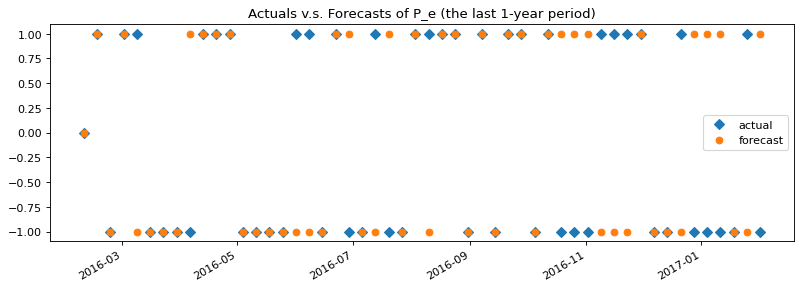

In [ ]:
# plot
plot_binary_Pe(direc, test_size)

#### Evaluate forecast accuracy

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.6154


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         17  0  10   27
0           0  1   0    1
1          10  0  14   24
All        27  1  24   52

Accuracy: 0.62


Classification Report

              precision    recall  f1-score   support

          -1       0.63      0.63      0.63        27
           0       1.00      1.00      1.00         1
           1       0.58      0.58      0.58        24

    accuracy                           0.62        52
   macro avg       0.74      0.74      0.74        52
weighted avg       0.62      0.62      0.62        52



Check both of confusion matrix and classification report to examine the accuracy and the weighted average score.

### P_i prediction

#### Data preparation

In [ ]:
df = ene.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,2.147875,2.147800,NaN,NaN
2006-02-01,1.284375,1.284150,2.391215,2.391059
2006-02-08,1.895750,1.895800,1.737250,1.737233
2006-02-15,1.808650,1.808750,0.293783,0.293918
2006-02-22,5.597316,5.601735,50.555569,50.565680
...,...,...,...,...
2017-01-04,0.661686,0.717311,1.313836,1.237450
2017-01-11,0.387201,0.348523,0.850608,0.636425
2017-01-18,0.285051,0.212098,0.301791,0.142801
2017-01-25,0.362851,0.308098,0.755720,0.581282


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

#### Define and fit model

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=2, shuffle=False)

Epoch 1/100
10/10 - 2s - loss: 0.1516 - accuracy: 0.0021
Epoch 2/100
10/10 - 0s - loss: 0.0340 - accuracy: 0.0021
Epoch 3/100
10/10 - 0s - loss: 0.0374 - accuracy: 0.0021
Epoch 4/100
10/10 - 0s - loss: 0.0247 - accuracy: 0.0021
Epoch 5/100
10/10 - 0s - loss: 0.0288 - accuracy: 0.0021
Epoch 6/100
10/10 - 0s - loss: 0.0236 - accuracy: 0.0021
Epoch 7/100
10/10 - 0s - loss: 0.0271 - accuracy: 0.0021
Epoch 8/100
10/10 - 0s - loss: 0.0233 - accuracy: 0.0021
Epoch 9/100
10/10 - 0s - loss: 0.0264 - accuracy: 0.0021
Epoch 10/100
10/10 - 0s - loss: 0.0231 - accuracy: 0.0021
Epoch 11/100
10/10 - 0s - loss: 0.0258 - accuracy: 0.0021
Epoch 12/100
10/10 - 0s - loss: 0.0229 - accuracy: 0.0021
Epoch 13/100
10/10 - 0s - loss: 0.0256 - accuracy: 0.0021
Epoch 14/100
10/10 - 0s - loss: 0.0228 - accuracy: 0.0021
Epoch 15/100
10/10 - 0s - loss: 0.0255 - accuracy: 0.0021
Epoch 16/100
10/10 - 0s - loss: 0.0227 - accuracy: 0.0021
Epoch 17/100
10/10 - 0s - loss: 0.0255 - accuracy: 0.0021
Epoch 18/100
10/10 - 0s

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

# check length of predict
len(predict)

52

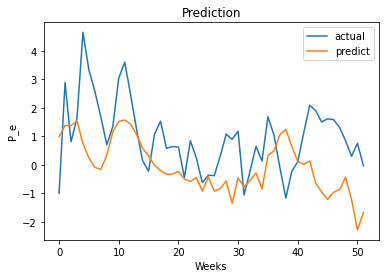

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.616


#### Convert to binary variable
Convert one-year prediction results to binary variable.

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.002715,0.980993
1,2.884630,1.384743
2,0.808127,1.375448
3,1.625690,1.539109
4,4.651038,0.750686


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.002715,0.980993,0,0
1,2.884630,1.384743,0,0
2,0.808127,1.375448,0,0
3,1.625690,1.539109,0,0
4,4.651038,0.750686,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5962
When threshold = 0.02, accuracy score = 0.5769
When threshold = 0.03, accuracy score = 0.5769
When threshold = 0.04, accuracy score = 0.5769


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.5769
When threshold = 0.06, accuracy score = 0.5577
When threshold = 0.07, accuracy score = 0.5769
When threshold = 0.08, accuracy score = 0.5577
When threshold = 0.09, accuracy score = 0.5385
When threshold = 0.1, accuracy score = 0.5577
When threshold = 0.11, accuracy score = 0.5577
When threshold = 0.12, accuracy score = 0.5385
When threshold = 0.13, accuracy score = 0.5385
When threshold = 0.14, accuracy score = 0.5192
When threshold = 0.15, accuracy score = 0.5
When threshold = 0.16, accuracy score = 0.5
When threshold = 0.17, accuracy score = 0.4808
When threshold = 0.18, accuracy score = 0.4808
When threshold = 0.19, accuracy score = 0.4615
When threshold = 0.2, accuracy score = 0.4423
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.002715,0.980993,0,0
1,2.884630,1.384743,1,1
2,0.808127,1.375448,-1,-1
3,1.625690,1.539109,1,1
4,4.651038,0.750686,1,-1


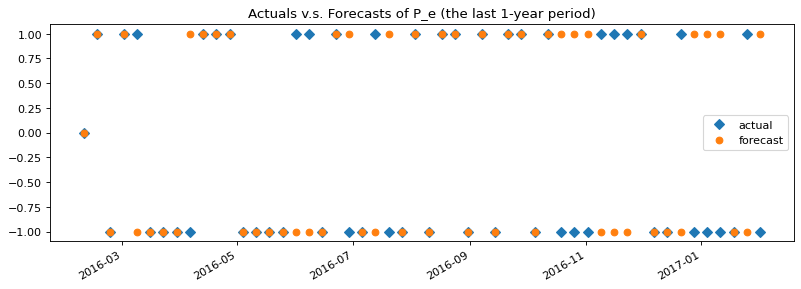

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

#### Evaluate forecast accuracy

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.6346


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         18  0  10   28
0           0  1   0    1
1           9  0  14   23
All        27  1  24   52

Accuracy: 0.63


Classification Report

              precision    recall  f1-score   support

          -1       0.67      0.64      0.65        28
           0       1.00      1.00      1.00         1
           1       0.58      0.61      0.60        23

    accuracy                           0.63        52
   macro avg       0.75      0.75      0.75        52
weighted avg       0.64      0.63      0.64        52



Check both of confusion matrix and classification report to examine the accuracy and the weighted average score.

# Apply the above workflow to all the sectors

## com, Commodities

### P_e prediction

**1.Data preparation**

In [ ]:
df = com.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.014125,-0.014125,NaN,NaN
2006-02-01,-1.736050,-1.736050,-0.360058,-0.360058
2006-02-08,0.263175,0.263175,0.181027,0.181027
2006-02-15,0.413725,0.413725,0.918998,0.918998
2006-02-22,2.789450,2.789450,2.082976,2.082976
...,...,...,...,...
2017-01-04,-0.251834,-0.285387,-0.478978,-0.516618
2017-01-11,-0.438259,-0.445387,-0.051113,-0.061928
2017-01-18,-0.831834,-0.844362,-0.332779,-0.351598
2017-01-25,0.254241,0.257413,1.714244,1.720707


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

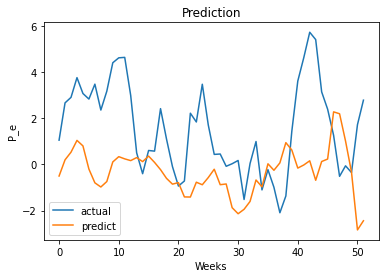

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.788


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,1.049543,-0.503458
1,2.664968,0.197662
2,2.903806,0.529400
3,3.758080,1.040131
4,3.070336,0.800879


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,1.049543,-0.503458,0,0
1,2.664968,0.197662,0,0
2,2.903806,0.529400,0,0
3,3.758080,1.040131,0,0
4,3.070336,0.800879,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5385
When threshold = 0.02, accuracy score = 0.5385
When threshold = 0.03, accuracy score = 0.5192
When threshold = 0.04, accuracy score = 0.5192


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.5192
When threshold = 0.06, accuracy score = 0.5192
When threshold = 0.07, accuracy score = 0.5192
When threshold = 0.08, accuracy score = 0.5
When threshold = 0.09, accuracy score = 0.4808
When threshold = 0.1, accuracy score = 0.5
When threshold = 0.11, accuracy score = 0.5
When threshold = 0.12, accuracy score = 0.5
When threshold = 0.13, accuracy score = 0.5
When threshold = 0.14, accuracy score = 0.4808
When threshold = 0.15, accuracy score = 0.4808
When threshold = 0.16, accuracy score = 0.4808
When threshold = 0.17, accuracy score = 0.4808
When threshold = 0.18, accuracy score = 0.4615
When threshold = 0.19, accuracy score = 0.4231
When threshold = 0.2, accuracy score = 0.4231
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,1.049543,-0.503458,0,0
1,2.664968,0.197662,1,1
2,2.903806,0.529400,1,1
3,3.758080,1.040131,1,1
4,3.070336,0.800879,-1,-1


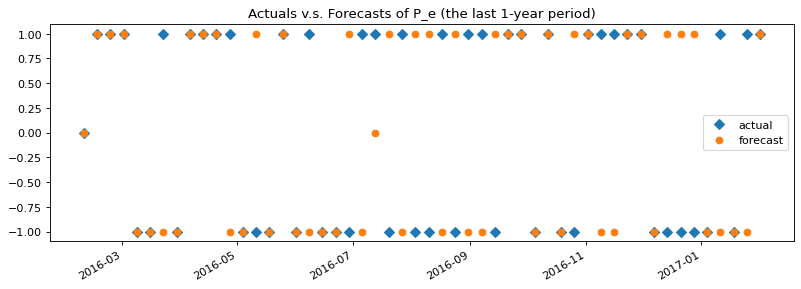

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5385


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         13  0  11   24
0           0  1   0    1
1          12  1  14   27
All        25  2  25   52

Accuracy: 0.54


Classification Report

              precision    recall  f1-score   support

          -1       0.52      0.54      0.53        24
           0       0.50      1.00      0.67         1
           1       0.56      0.52      0.54        27

    accuracy                           0.54        52
   macro avg       0.53      0.69      0.58        52
weighted avg       0.54      0.54      0.54        52



### P_i prediction

**1.Data preparation**

In [ ]:
df = com.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.014125,-0.014125,NaN,NaN
2006-02-01,-1.736050,-1.736050,-0.360058,-0.360058
2006-02-08,0.263175,0.263175,0.181027,0.181027
2006-02-15,0.413725,0.413725,0.918998,0.918998
2006-02-22,2.789450,2.789450,2.082976,2.082976
...,...,...,...,...
2017-01-04,-0.251834,-0.285387,-0.478978,-0.516618
2017-01-11,-0.438259,-0.445387,-0.051113,-0.061928
2017-01-18,-0.831834,-0.844362,-0.332779,-0.351598
2017-01-25,0.254241,0.257413,1.714244,1.720707


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

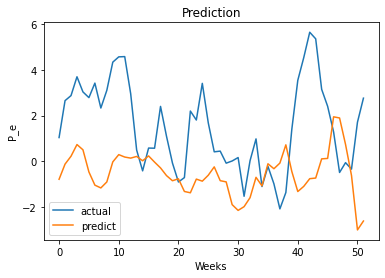

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.924


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,1.044033,-0.775865
1,2.653751,-0.114530
2,2.873502,0.229375
3,3.694783,0.738522
4,3.034595,0.509605


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,1.044033,-0.775865,0,0
1,2.653751,-0.114530,0,0
2,2.873502,0.229375,0,0
3,3.694783,0.738522,0,0
4,3.034595,0.509605,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5192
When threshold = 0.02, accuracy score = 0.5192
When threshold = 0.03, accuracy score = 0.5192
When threshold = 0.04, accuracy score = 0.5192
When threshold = 0.05, accuracy score = 0.5


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.4615
When threshold = 0.07, accuracy score = 0.4615
When threshold = 0.08, accuracy score = 0.4615
When threshold = 0.09, accuracy score = 0.4615
When threshold = 0.1, accuracy score = 0.4615
When threshold = 0.11, accuracy score = 0.4808
When threshold = 0.12, accuracy score = 0.4808
When threshold = 0.13, accuracy score = 0.4615
When threshold = 0.14, accuracy score = 0.4615
When threshold = 0.15, accuracy score = 0.4615
When threshold = 0.16, accuracy score = 0.4615
When threshold = 0.17, accuracy score = 0.4615
When threshold = 0.18, accuracy score = 0.4615
When threshold = 0.19, accuracy score = 0.4423
When threshold = 0.2, accuracy score = 0.4423
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,1.044033,-0.775865,0,0
1,2.653751,-0.114530,1,1
2,2.873502,0.229375,1,1
3,3.694783,0.738522,1,1
4,3.034595,0.509605,-1,-1


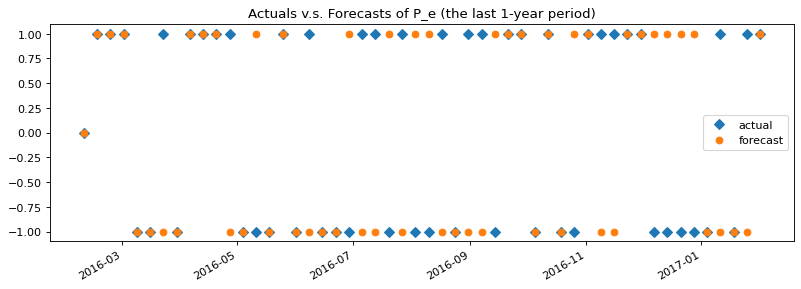

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5385


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         13  0  11   24
0           0  1   0    1
1          13  0  14   27
All        26  1  25   52

Accuracy: 0.54


Classification Report

              precision    recall  f1-score   support

          -1       0.50      0.54      0.52        24
           0       1.00      1.00      1.00         1
           1       0.56      0.52      0.54        27

    accuracy                           0.54        52
   macro avg       0.69      0.69      0.69        52
weighted avg       0.54      0.54      0.54        52



## con, Consumer Goods

### P_e prediction

**1.Data preparation**

In [ ]:
df = con.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-3.624925,-3.624925,NaN,NaN
2006-02-01,-4.567325,-4.567325,-5.661144,-5.661144
2006-02-08,-3.964775,-3.964775,-6.020297,-6.020297
2006-02-15,-3.248225,-3.248225,-5.091682,-5.091682
2006-02-22,-0.488650,-0.488650,0.051539,0.051539
...,...,...,...,...
2017-01-04,0.111809,0.111809,0.015865,0.015865
2017-01-11,0.464109,0.464109,0.363493,0.363493
2017-01-18,-0.143972,-0.143972,-0.114769,-0.114769
2017-01-25,0.093028,0.093028,0.771079,0.771079


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

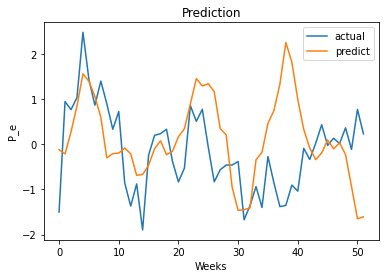

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.169


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.500179,-0.118808
1,0.945167,-0.213311
2,0.765617,0.271981
3,1.033787,0.848141
4,2.478227,1.557119


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.500179,-0.118808,0,0
1,0.945167,-0.213311,0,0
2,0.765617,0.271981,0,0
3,1.033787,0.848141,0,0
4,2.478227,1.557119,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.4038
When threshold = 0.02, accuracy score = 0.4038
When threshold = 0.03, accuracy score = 0.3846
When threshold = 0.04, accuracy score = 0.3654
When threshold = 0.05, accuracy score = 0.3462


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.3462
When threshold = 0.07, accuracy score = 0.3462
When threshold = 0.08, accuracy score = 0.3462
When threshold = 0.09, accuracy score = 0.3462
When threshold = 0.1, accuracy score = 0.3462
When threshold = 0.11, accuracy score = 0.3462
When threshold = 0.12, accuracy score = 0.3462
When threshold = 0.13, accuracy score = 0.3269
When threshold = 0.14, accuracy score = 0.3462
When threshold = 0.15, accuracy score = 0.3269
When threshold = 0.16, accuracy score = 0.3269
When threshold = 0.17, accuracy score = 0.3077
When threshold = 0.18, accuracy score = 0.2885
When threshold = 0.19, accuracy score = 0.2885
When threshold = 0.2, accuracy score = 0.3077
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.500179,-0.118808,0,0
1,0.945167,-0.213311,1,-1
2,0.765617,0.271981,-1,1
3,1.033787,0.848141,1,1
4,2.478227,1.557119,1,1


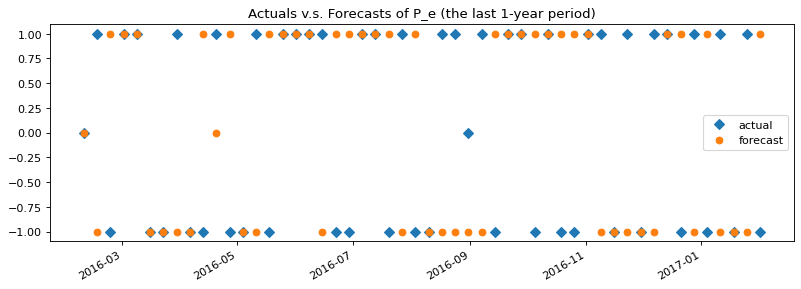

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.4038


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1          8  0  15   23
0           1  1   0    2
1          14  1  12   27
All        23  2  27   52

Accuracy: 0.40


Classification Report

              precision    recall  f1-score   support

          -1       0.35      0.35      0.35        23
           0       0.50      0.50      0.50         2
           1       0.44      0.44      0.44        27

    accuracy                           0.40        52
   macro avg       0.43      0.43      0.43        52
weighted avg       0.40      0.40      0.40        52



### P_i prediction

**1.Data preparation**

In [ ]:
df = con.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-3.624925,-3.624925,NaN,NaN
2006-02-01,-4.567325,-4.567325,-5.661144,-5.661144
2006-02-08,-3.964775,-3.964775,-6.020297,-6.020297
2006-02-15,-3.248225,-3.248225,-5.091682,-5.091682
2006-02-22,-0.488650,-0.488650,0.051539,0.051539
...,...,...,...,...
2017-01-04,0.111809,0.111809,0.015865,0.015865
2017-01-11,0.464109,0.464109,0.363493,0.363493
2017-01-18,-0.143972,-0.143972,-0.114769,-0.114769
2017-01-25,0.093028,0.093028,0.771079,0.771079


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

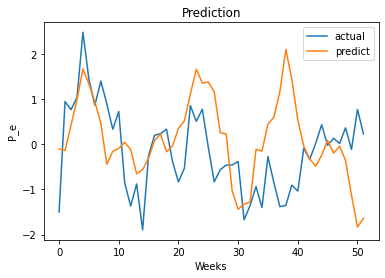

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.151


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.500179,-0.101526
1,0.945167,-0.137465
2,0.765617,0.420775
3,1.033787,0.981857
4,2.478227,1.668345


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.500179,-0.101526,0,0
1,0.945167,-0.137465,0,0
2,0.765617,0.420775,0,0
3,1.033787,0.981857,0,0
4,2.478227,1.668345,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.4423
When threshold = 0.02, accuracy score = 0.4423
When threshold = 0.03, accuracy score = 0.4231
When threshold = 0.04, accuracy score = 0.3654


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.3654
When threshold = 0.06, accuracy score = 0.3654
When threshold = 0.07, accuracy score = 0.3462
When threshold = 0.08, accuracy score = 0.3462
When threshold = 0.09, accuracy score = 0.3462
When threshold = 0.1, accuracy score = 0.3462
When threshold = 0.11, accuracy score = 0.3654
When threshold = 0.12, accuracy score = 0.3654
When threshold = 0.13, accuracy score = 0.3654
When threshold = 0.14, accuracy score = 0.3462
When threshold = 0.15, accuracy score = 0.3654
When threshold = 0.16, accuracy score = 0.3846
When threshold = 0.17, accuracy score = 0.3654
When threshold = 0.18, accuracy score = 0.3462
When threshold = 0.19, accuracy score = 0.3462
When threshold = 0.2, accuracy score = 0.3462
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.500179,-0.101526,0,0
1,0.945167,-0.137465,1,-1
2,0.765617,0.420775,-1,1
3,1.033787,0.981857,1,1
4,2.478227,1.668345,1,1


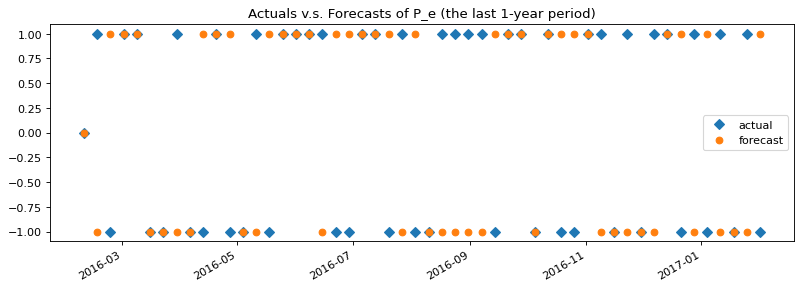

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.4423


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1          9  0  14   23
0           0  1   0    1
1          15  0  13   28
All        24  1  27   52

Accuracy: 0.44


Classification Report

              precision    recall  f1-score   support

          -1       0.38      0.39      0.38        23
           0       1.00      1.00      1.00         1
           1       0.48      0.46      0.47        28

    accuracy                           0.44        52
   macro avg       0.62      0.62      0.62        52
weighted avg       0.44      0.44      0.44        52



## fin, Finance

### P_e prediction

**1.Data preparation**

In [ ]:
df = fin.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,0.021075,0.021075,NaN,NaN
2006-02-01,0.021075,0.021075,0.045338,0.045338
2006-02-08,-0.170525,-0.170525,-0.604156,-0.604156
2006-02-15,-0.683550,-0.683550,-0.317096,-0.317096
2006-02-22,4.848537,4.848537,88.656942,88.656942
...,...,...,...,...
2017-01-04,0.405500,0.394175,0.825428,0.819097
2017-01-11,0.605575,0.598150,1.080367,1.081876
2017-01-18,0.404529,0.382850,0.259339,0.230475
2017-01-25,0.043754,-0.005156,0.425195,0.381228


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

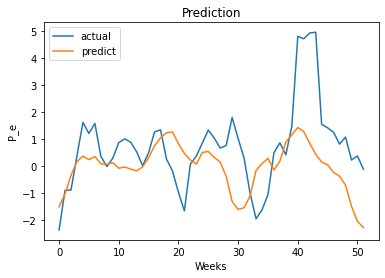

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.622


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-2.363353,-1.505411
1,-0.892131,-1.028100
2,-0.883494,-0.339640
3,0.390551,0.173589
4,1.622340,0.372572


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-2.363353,-1.505411,0,0
1,-0.892131,-1.028100,0,0
2,-0.883494,-0.339640,0,0
3,0.390551,0.173589,0,0
4,1.622340,0.372572,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.6538


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.02, accuracy score = 0.6346
When threshold = 0.03, accuracy score = 0.6346
When threshold = 0.04, accuracy score = 0.6346
When threshold = 0.05, accuracy score = 0.5962
When threshold = 0.06, accuracy score = 0.5769
When threshold = 0.07, accuracy score = 0.5577
When threshold = 0.08, accuracy score = 0.5385
When threshold = 0.09, accuracy score = 0.5
When threshold = 0.1, accuracy score = 0.5
When threshold = 0.11, accuracy score = 0.4808
When threshold = 0.12, accuracy score = 0.4615
When threshold = 0.13, accuracy score = 0.4808
When threshold = 0.14, accuracy score = 0.5
When threshold = 0.15, accuracy score = 0.4808
When threshold = 0.16, accuracy score = 0.5
When threshold = 0.17, accuracy score = 0.4808
When threshold = 0.18, accuracy score = 0.4615
When threshold = 0.19, accuracy score = 0.4615
When threshold = 0.2, accuracy score = 0.4231
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-2.363353,-1.505411,0,0
1,-0.892131,-1.028100,1,1
2,-0.883494,-0.339640,0,1
3,0.390551,0.173589,1,1
4,1.622340,0.372572,1,1


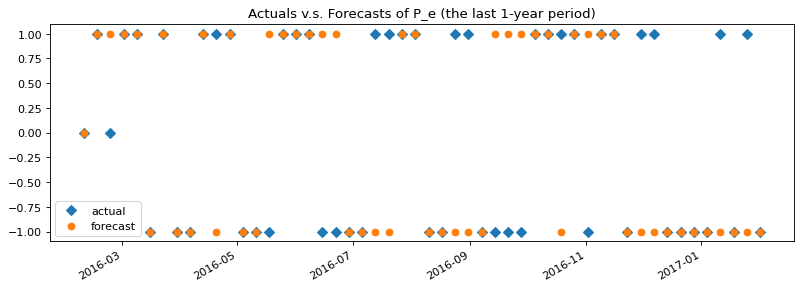

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.6538


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         17  0   7   24
0           0  1   1    2
1          10  0  16   26
All        27  1  24   52

Accuracy: 0.65


Classification Report

              precision    recall  f1-score   support

          -1       0.63      0.71      0.67        24
           0       1.00      0.50      0.67         2
           1       0.67      0.62      0.64        26

    accuracy                           0.65        52
   macro avg       0.77      0.61      0.66        52
weighted avg       0.66      0.65      0.65        52



### P_i prediction

**1.Data preparation**

In [ ]:
df = fin.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,0.021075,0.021075,NaN,NaN
2006-02-01,0.021075,0.021075,0.045338,0.045338
2006-02-08,-0.170525,-0.170525,-0.604156,-0.604156
2006-02-15,-0.683550,-0.683550,-0.317096,-0.317096
2006-02-22,4.848537,4.848537,88.656942,88.656942
...,...,...,...,...
2017-01-04,0.405500,0.394175,0.825428,0.819097
2017-01-11,0.605575,0.598150,1.080367,1.081876
2017-01-18,0.404529,0.382850,0.259339,0.230475
2017-01-25,0.043754,-0.005156,0.425195,0.381228


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

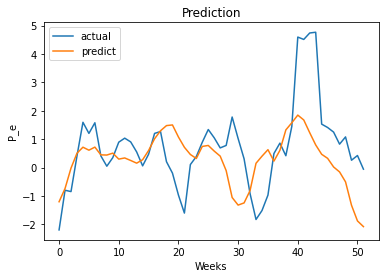

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.460


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-2.194919,-1.202669
1,-0.797946,-0.736887
2,-0.844839,-0.018124
3,0.408852,0.505929
4,1.595358,0.718270


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-2.194919,-1.202669,0,0
1,-0.797946,-0.736887,0,0
2,-0.844839,-0.018124,0,0
3,0.408852,0.505929,0,0
4,1.595358,0.718270,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.6346
When threshold = 0.02, accuracy score = 0.6346
When threshold = 0.03, accuracy score = 0.6346
When threshold = 0.04, accuracy score = 0.6154


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.5962
When threshold = 0.06, accuracy score = 0.5962
When threshold = 0.07, accuracy score = 0.5577
When threshold = 0.08, accuracy score = 0.5577
When threshold = 0.09, accuracy score = 0.5192
When threshold = 0.1, accuracy score = 0.5
When threshold = 0.11, accuracy score = 0.4615
When threshold = 0.12, accuracy score = 0.4423
When threshold = 0.13, accuracy score = 0.4423
When threshold = 0.14, accuracy score = 0.4615
When threshold = 0.15, accuracy score = 0.5
When threshold = 0.16, accuracy score = 0.5
When threshold = 0.17, accuracy score = 0.4808
When threshold = 0.18, accuracy score = 0.4615
When threshold = 0.19, accuracy score = 0.4615
When threshold = 0.2, accuracy score = 0.4423
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-2.194919,-1.202669,0,0
1,-0.797946,-0.736887,1,1
2,-0.844839,-0.018124,-1,1
3,0.408852,0.505929,1,1
4,1.595358,0.718270,1,1


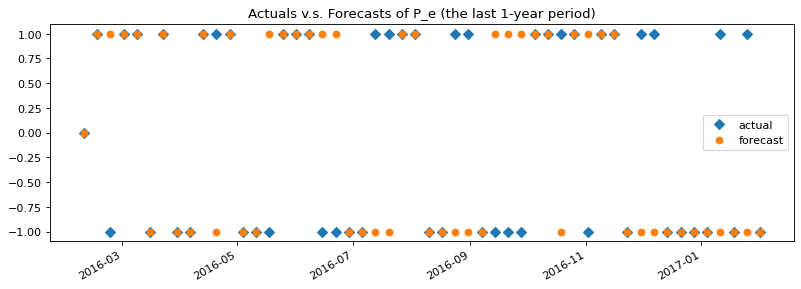

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.6538


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         17  0   8   25
0           0  1   0    1
1          10  0  16   26
All        27  1  24   52

Accuracy: 0.65


Classification Report

              precision    recall  f1-score   support

          -1       0.63      0.68      0.65        25
           0       1.00      1.00      1.00         1
           1       0.67      0.62      0.64        26

    accuracy                           0.65        52
   macro avg       0.77      0.77      0.76        52
weighted avg       0.66      0.65      0.65        52



## hea, Health/Biotech

### P_e prediction

**1.Data preparation**

In [ ]:
df = hea.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,1.539600,1.666450,NaN,NaN
2006-02-01,1.562225,1.687900,1.829210,1.906942
2006-02-08,-0.120743,-0.097759,-0.765631,-0.767046
2006-02-15,-1.257318,-1.348109,-1.285149,-1.425835
2006-02-22,-0.988043,-1.060959,0.033709,-0.068342
...,...,...,...,...
2017-01-04,-0.166825,-0.128975,0.751072,0.801515
2017-01-11,0.441291,0.517778,1.146627,1.196199
2017-01-18,0.191191,0.239303,0.966919,0.993742
2017-01-25,-0.235966,-0.231093,0.179685,0.157618


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

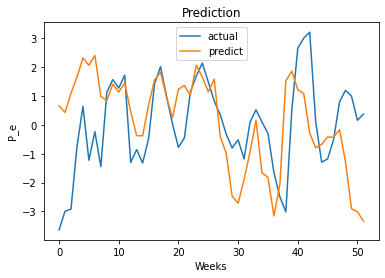

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.959


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-3.640887,0.657498
1,-2.993651,0.431254
2,-2.918105,1.095629
3,-0.753981,1.654240
4,0.641513,2.320172


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-3.640887,0.657498,0,0
1,-2.993651,0.431254,0,0
2,-2.918105,1.095629,0,0
3,-0.753981,1.654240,0,0
4,0.641513,2.320172,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.6346
When threshold = 0.02, accuracy score = 0.6346
When threshold = 0.03, accuracy score = 0.6346
When threshold = 0.04, accuracy score = 0.6346
When threshold = 0.05, accuracy score = 0.6346


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.6346
When threshold = 0.07, accuracy score = 0.6346
When threshold = 0.08, accuracy score = 0.6154
When threshold = 0.09, accuracy score = 0.6154
When threshold = 0.1, accuracy score = 0.6154
When threshold = 0.11, accuracy score = 0.5962
When threshold = 0.12, accuracy score = 0.5769
When threshold = 0.13, accuracy score = 0.5769
When threshold = 0.14, accuracy score = 0.5577
When threshold = 0.15, accuracy score = 0.5577
When threshold = 0.16, accuracy score = 0.5385
When threshold = 0.17, accuracy score = 0.5385
When threshold = 0.18, accuracy score = 0.5385
When threshold = 0.19, accuracy score = 0.5385
When threshold = 0.2, accuracy score = 0.5385
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-3.640887,0.657498,0,0
1,-2.993651,0.431254,1,-1
2,-2.918105,1.095629,1,1
3,-0.753981,1.654240,1,1
4,0.641513,2.320172,1,1


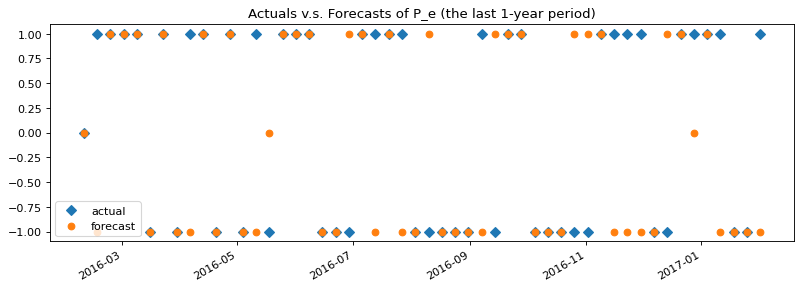

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.6346


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         16  1   6   23
0           0  1   0    1
1          11  1  16   28
All        27  3  22   52

Accuracy: 0.63


Classification Report

              precision    recall  f1-score   support

          -1       0.59      0.70      0.64        23
           0       0.33      1.00      0.50         1
           1       0.73      0.57      0.64        28

    accuracy                           0.63        52
   macro avg       0.55      0.76      0.59        52
weighted avg       0.66      0.63      0.64        52



### P_i prediction

**1.Data preparation**

In [ ]:
df = hea.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,1.539600,1.666450,NaN,NaN
2006-02-01,1.562225,1.687900,1.829210,1.906942
2006-02-08,-0.120743,-0.097759,-0.765631,-0.767046
2006-02-15,-1.257318,-1.348109,-1.285149,-1.425835
2006-02-22,-0.988043,-1.060959,0.033709,-0.068342
...,...,...,...,...
2017-01-04,-0.166825,-0.128975,0.751072,0.801515
2017-01-11,0.441291,0.517778,1.146627,1.196199
2017-01-18,0.191191,0.239303,0.966919,0.993742
2017-01-25,-0.235966,-0.231093,0.179685,0.157618


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

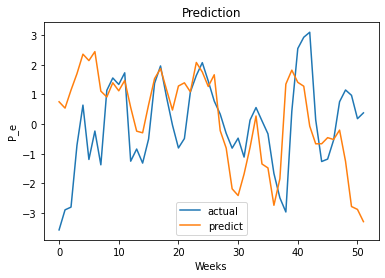

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.895


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-3.568459,0.749138
1,-2.892240,0.535900
2,-2.799965,1.142581
3,-0.711958,1.696843
4,0.636864,2.353349


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-3.568459,0.749138,0,0
1,-2.892240,0.535900,0,0
2,-2.799965,1.142581,0,0
3,-0.711958,1.696843,0,0
4,0.636864,2.353349,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.6538
When threshold = 0.02, accuracy score = 0.6538
When threshold = 0.03, accuracy score = 0.6538
When threshold = 0.04, accuracy score = 0.6538
When threshold = 0.05, accuracy score = 0.6538


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.6346
When threshold = 0.07, accuracy score = 0.6346
When threshold = 0.08, accuracy score = 0.6346
When threshold = 0.09, accuracy score = 0.6154
When threshold = 0.1, accuracy score = 0.5769
When threshold = 0.11, accuracy score = 0.5577
When threshold = 0.12, accuracy score = 0.5577
When threshold = 0.13, accuracy score = 0.5577
When threshold = 0.14, accuracy score = 0.5385
When threshold = 0.15, accuracy score = 0.5385
When threshold = 0.16, accuracy score = 0.5385
When threshold = 0.17, accuracy score = 0.5385
When threshold = 0.18, accuracy score = 0.5192
When threshold = 0.19, accuracy score = 0.5192
When threshold = 0.2, accuracy score = 0.5192
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-3.568459,0.749138,0,0
1,-2.892240,0.535900,1,-1
2,-2.799965,1.142581,1,1
3,-0.711958,1.696843,1,1
4,0.636864,2.353349,1,1


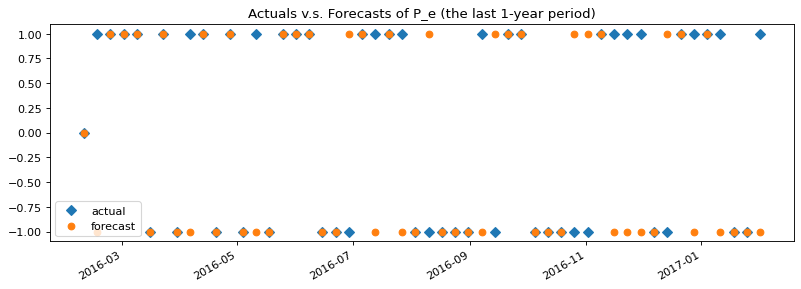

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.6538


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         17  0   6   23
0           0  1   0    1
1          12  0  16   28
All        29  1  22   52

Accuracy: 0.65


Classification Report

              precision    recall  f1-score   support

          -1       0.59      0.74      0.65        23
           0       1.00      1.00      1.00         1
           1       0.73      0.57      0.64        28

    accuracy                           0.65        52
   macro avg       0.77      0.77      0.76        52
weighted avg       0.67      0.65      0.65        52



## ind, Industrials

### P_e prediction

**1.Data preparation**

In [ ]:
df = ind.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.575200,-0.575200,NaN,NaN
2006-02-01,-1.196375,-1.196375,-0.412078,-0.412078
2006-02-08,-1.510100,-1.510100,-1.054217,-1.054217
2006-02-15,-1.510100,-1.510100,-0.088663,-0.088663
2006-02-22,-0.313725,-0.313725,1.013055,1.013055
...,...,...,...,...
2017-01-04,0.017925,0.017925,-0.151711,-0.151711
2017-01-11,0.517276,0.517276,0.664614,0.664614
2017-01-18,0.301836,0.301836,0.203925,0.203925
2017-01-25,0.457561,0.457561,1.135918,1.135918


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

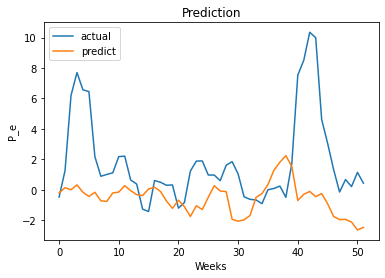

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.779


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-0.487870,-0.213164
1,1.254171,0.131831
2,6.189834,-0.002382
3,7.700077,0.313885
4,6.564281,-0.166677


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.487870,-0.213164,0,0
1,1.254171,0.131831,0,0
2,6.189834,-0.002382,0,0
3,7.700077,0.313885,0,0
4,6.564281,-0.166677,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5577
When threshold = 0.02, accuracy score = 0.5385
When threshold = 0.03, accuracy score = 0.5385
When threshold = 0.04, accuracy score = 0.5192


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.5192
When threshold = 0.06, accuracy score = 0.4808
When threshold = 0.07, accuracy score = 0.4808
When threshold = 0.08, accuracy score = 0.4615
When threshold = 0.09, accuracy score = 0.4615
When threshold = 0.1, accuracy score = 0.4615
When threshold = 0.11, accuracy score = 0.4423
When threshold = 0.12, accuracy score = 0.4038
When threshold = 0.13, accuracy score = 0.3846
When threshold = 0.14, accuracy score = 0.3846
When threshold = 0.15, accuracy score = 0.3846
When threshold = 0.16, accuracy score = 0.3846
When threshold = 0.17, accuracy score = 0.3654
When threshold = 0.18, accuracy score = 0.3462
When threshold = 0.19, accuracy score = 0.3269
When threshold = 0.2, accuracy score = 0.3077
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.487870,-0.213164,0,0
1,1.254171,0.131831,1,1
2,6.189834,-0.002382,1,-1
3,7.700077,0.313885,1,1
4,6.564281,-0.166677,-1,-1


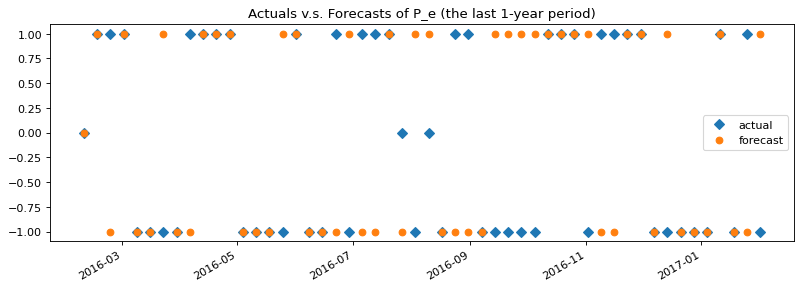

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5577


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         15  0  11   26
0           1  1   1    3
1          10  0  13   23
All        26  1  25   52

Accuracy: 0.56


Classification Report

              precision    recall  f1-score   support

          -1       0.58      0.58      0.58        26
           0       1.00      0.33      0.50         3
           1       0.52      0.57      0.54        23

    accuracy                           0.56        52
   macro avg       0.70      0.49      0.54        52
weighted avg       0.58      0.56      0.56        52



### P_i prediction

**1.Data preparation**

In [ ]:
df = ind.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.575200,-0.575200,NaN,NaN
2006-02-01,-1.196375,-1.196375,-0.412078,-0.412078
2006-02-08,-1.510100,-1.510100,-1.054217,-1.054217
2006-02-15,-1.510100,-1.510100,-0.088663,-0.088663
2006-02-22,-0.313725,-0.313725,1.013055,1.013055
...,...,...,...,...
2017-01-04,0.017925,0.017925,-0.151711,-0.151711
2017-01-11,0.517276,0.517276,0.664614,0.664614
2017-01-18,0.301836,0.301836,0.203925,0.203925
2017-01-25,0.457561,0.457561,1.135918,1.135918


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

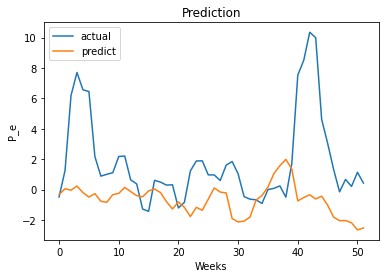

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.836


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-0.487870,-0.331356
1,1.254171,0.053125
2,6.189834,-0.042086
3,7.700077,0.231262
4,6.564281,-0.202490


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.487870,-0.331356,0,0
1,1.254171,0.053125,0,0
2,6.189834,-0.042086,0,0
3,7.700077,0.231262,0,0
4,6.564281,-0.202490,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5385
When threshold = 0.02, accuracy score = 0.5385
When threshold = 0.03, accuracy score = 0.5385
When threshold = 0.04, accuracy score = 0.5192


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.5192
When threshold = 0.06, accuracy score = 0.5192
When threshold = 0.07, accuracy score = 0.5192
When threshold = 0.08, accuracy score = 0.4808
When threshold = 0.09, accuracy score = 0.4615
When threshold = 0.1, accuracy score = 0.4615
When threshold = 0.11, accuracy score = 0.4423
When threshold = 0.12, accuracy score = 0.4231
When threshold = 0.13, accuracy score = 0.4038
When threshold = 0.14, accuracy score = 0.4038
When threshold = 0.15, accuracy score = 0.3846
When threshold = 0.16, accuracy score = 0.3846
When threshold = 0.17, accuracy score = 0.3654
When threshold = 0.18, accuracy score = 0.3654
When threshold = 0.19, accuracy score = 0.3654
When threshold = 0.2, accuracy score = 0.3462
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.487870,-0.331356,0,0
1,1.254171,0.053125,1,1
2,6.189834,-0.042086,1,-1
3,7.700077,0.231262,1,1
4,6.564281,-0.202490,-1,-1


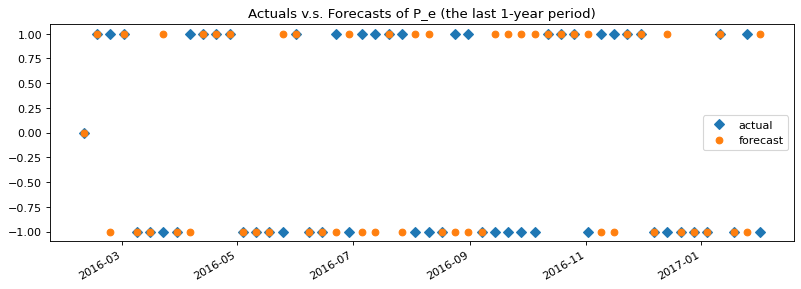

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5577


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         15  0  12   27
0           0  1   0    1
1          11  0  13   24
All        26  1  25   52

Accuracy: 0.56


Classification Report

              precision    recall  f1-score   support

          -1       0.58      0.56      0.57        27
           0       1.00      1.00      1.00         1
           1       0.52      0.54      0.53        24

    accuracy                           0.56        52
   macro avg       0.70      0.70      0.70        52
weighted avg       0.56      0.56      0.56        52



## lcb, Large Capital Blend

### P_e prediction

**1.Data preparation**

In [ ]:
df = lcb.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,0.293650,0.644450,NaN,NaN
2006-02-01,0.125025,-0.014450,0.361387,0.193913
2006-02-08,0.185100,0.154650,-0.414751,-0.362365
2006-02-15,0.162575,0.212025,0.703606,0.300621
2006-02-22,0.422650,0.838075,18.224093,66.665373
...,...,...,...,...
2017-01-04,0.335636,0.617536,0.662931,0.892140
2017-01-11,-0.021377,0.055632,0.253186,0.257515
2017-01-18,0.010498,0.083882,0.190275,0.217185
2017-01-25,-0.031052,0.018732,0.575074,0.588567


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

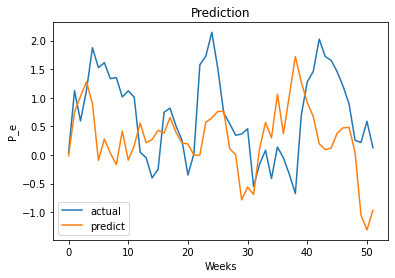

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.986


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,0.036858,-0.014691
1,1.123953,0.751892
2,0.594688,1.025139
3,1.130746,1.279451
4,1.875674,0.897812


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,0.036858,-0.014691,0,0
1,1.123953,0.751892,0,0
2,0.594688,1.025139,0,0
3,1.130746,1.279451,0,0
4,1.875674,0.897812,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5
When threshold = 0.02, accuracy score = 0.4808
When threshold = 0.03, accuracy score = 0.4808
When threshold = 0.04, accuracy score = 0.4808


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.4615
When threshold = 0.06, accuracy score = 0.4615
When threshold = 0.07, accuracy score = 0.4808
When threshold = 0.08, accuracy score = 0.4423
When threshold = 0.09, accuracy score = 0.4231
When threshold = 0.1, accuracy score = 0.3846
When threshold = 0.11, accuracy score = 0.3462
When threshold = 0.12, accuracy score = 0.3462
When threshold = 0.13, accuracy score = 0.3269
When threshold = 0.14, accuracy score = 0.3269
When threshold = 0.15, accuracy score = 0.2885
When threshold = 0.16, accuracy score = 0.2885
When threshold = 0.17, accuracy score = 0.3077
When threshold = 0.18, accuracy score = 0.3077
When threshold = 0.19, accuracy score = 0.25
When threshold = 0.2, accuracy score = 0.25
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,0.036858,-0.014691,0,0
1,1.123953,0.751892,1,1
2,0.594688,1.025139,-1,1
3,1.130746,1.279451,1,1
4,1.875674,0.897812,1,-1


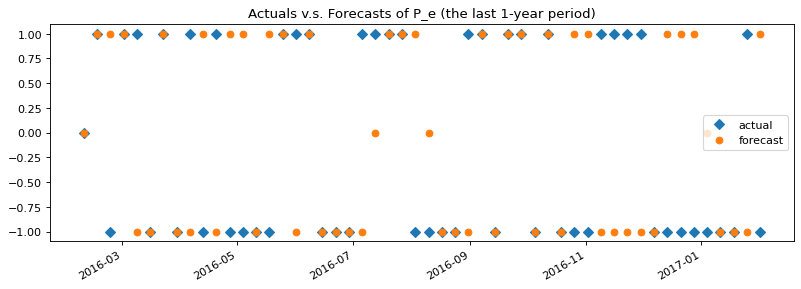

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         14  2  12   28
0           0  1   0    1
1          11  1  11   23
All        25  4  23   52

Accuracy: 0.50


Classification Report

              precision    recall  f1-score   support

          -1       0.56      0.50      0.53        28
           0       0.25      1.00      0.40         1
           1       0.48      0.48      0.48        23

    accuracy                           0.50        52
   macro avg       0.43      0.66      0.47        52
weighted avg       0.52      0.50      0.50        52



### P_i prediction

**1.Data preparation**

In [ ]:
df = lcb.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,0.293650,0.644450,NaN,NaN
2006-02-01,0.125025,-0.014450,0.361387,0.193913
2006-02-08,0.185100,0.154650,-0.414751,-0.362365
2006-02-15,0.162575,0.212025,0.703606,0.300621
2006-02-22,0.422650,0.838075,18.224093,66.665373
...,...,...,...,...
2017-01-04,0.335636,0.617536,0.662931,0.892140
2017-01-11,-0.021377,0.055632,0.253186,0.257515
2017-01-18,0.010498,0.083882,0.190275,0.217185
2017-01-25,-0.031052,0.018732,0.575074,0.588567


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

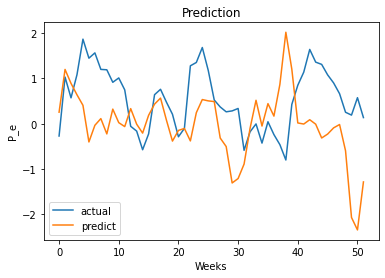

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.130


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-0.272068,0.254406
1,1.030605,1.199399
2,0.571545,0.891216
3,1.083163,0.639152
4,1.868311,0.406860


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.272068,0.254406,0,0
1,1.030605,1.199399,0,0
2,0.571545,0.891216,0,0
3,1.083163,0.639152,0,0
4,1.868311,0.406860,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5962
When threshold = 0.02, accuracy score = 0.5769
When threshold = 0.03, accuracy score = 0.5577
When threshold = 0.04, accuracy score = 0.5577


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.5385
When threshold = 0.06, accuracy score = 0.5
When threshold = 0.07, accuracy score = 0.4808
When threshold = 0.08, accuracy score = 0.4615
When threshold = 0.09, accuracy score = 0.4423
When threshold = 0.1, accuracy score = 0.4231
When threshold = 0.11, accuracy score = 0.3846
When threshold = 0.12, accuracy score = 0.3462
When threshold = 0.13, accuracy score = 0.3462
When threshold = 0.14, accuracy score = 0.3654
When threshold = 0.15, accuracy score = 0.3654
When threshold = 0.16, accuracy score = 0.3462
When threshold = 0.17, accuracy score = 0.3462
When threshold = 0.18, accuracy score = 0.3462
When threshold = 0.19, accuracy score = 0.3846
When threshold = 0.2, accuracy score = 0.3654
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.272068,0.254406,0,0
1,1.030605,1.199399,1,1
2,0.571545,0.891216,-1,-1
3,1.083163,0.639152,1,-1
4,1.868311,0.406860,1,-1


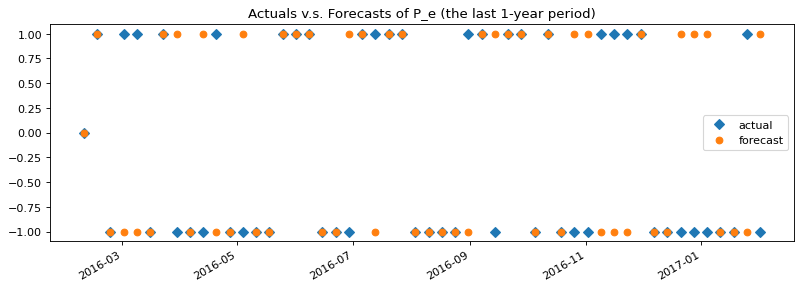

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.6154


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         18  0  11   29
0           0  1   0    1
1           9  0  13   22
All        27  1  24   52

Accuracy: 0.62


Classification Report

              precision    recall  f1-score   support

          -1       0.67      0.62      0.64        29
           0       1.00      1.00      1.00         1
           1       0.54      0.59      0.57        22

    accuracy                           0.62        52
   macro avg       0.74      0.74      0.74        52
weighted avg       0.62      0.62      0.62        52



## lcg, Large Capital Growth

### P_e prediction

**1.Data preparation**

In [ ]:
df = lcg.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.523432,0.310625,NaN,NaN
2006-02-01,0.284000,0.515625,0.535087,0.507485
2006-02-08,0.314825,0.126500,-0.276712,-0.625061
2006-02-15,0.328525,0.260950,0.358400,0.146419
2006-02-22,0.071275,-0.352825,15.766886,53.118657
...,...,...,...,...
2017-01-04,0.135321,0.644616,0.475553,1.125571
2017-01-11,-0.053260,0.150750,0.432236,0.632148
2017-01-18,-0.168310,-0.085225,0.360603,0.368860
2017-01-25,-0.377824,-0.497974,0.745246,0.424562


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

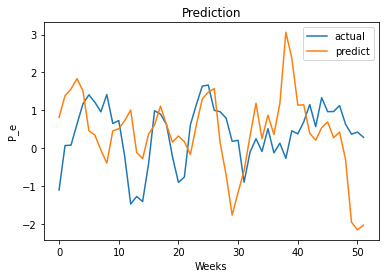

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.219


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.105656,0.811966
1,0.069377,1.386306
2,0.077866,1.560099
3,0.633973,1.836255
4,1.170113,1.514365


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.105656,0.811966,0,0
1,0.069377,1.386306,0,0
2,0.077866,1.560099,0,0
3,0.633973,1.836255,0,0
4,1.170113,1.514365,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.5769
When threshold = 0.02, accuracy score = 0.5769
When threshold = 0.03, accuracy score = 0.5385
When threshold = 0.04, accuracy score = 0.5192


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.5192
When threshold = 0.06, accuracy score = 0.5
When threshold = 0.07, accuracy score = 0.5
When threshold = 0.08, accuracy score = 0.5192
When threshold = 0.09, accuracy score = 0.5
When threshold = 0.1, accuracy score = 0.5
When threshold = 0.11, accuracy score = 0.5
When threshold = 0.12, accuracy score = 0.4808
When threshold = 0.13, accuracy score = 0.4808
When threshold = 0.14, accuracy score = 0.4808
When threshold = 0.15, accuracy score = 0.4808
When threshold = 0.16, accuracy score = 0.5
When threshold = 0.17, accuracy score = 0.5192
When threshold = 0.18, accuracy score = 0.5385
When threshold = 0.19, accuracy score = 0.5192
When threshold = 0.2, accuracy score = 0.5385
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.105656,0.811966,0,0
1,0.069377,1.386306,1,1
2,0.077866,1.560099,0,1
3,0.633973,1.836255,1,1
4,1.170113,1.514365,1,-1


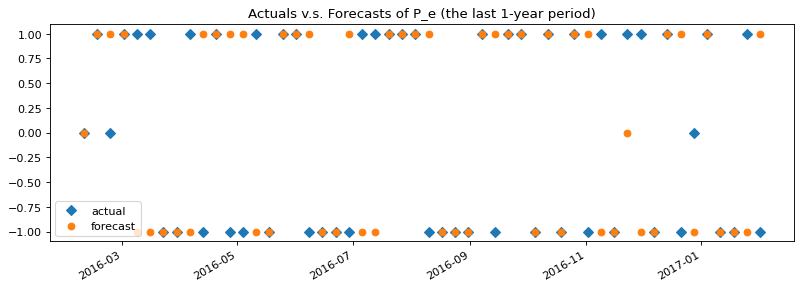

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5769


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         14  0  10   24
0           1  1   1    3
1           9  1  15   25
All        24  2  26   52

Accuracy: 0.58


Classification Report

              precision    recall  f1-score   support

          -1       0.58      0.58      0.58        24
           0       0.50      0.33      0.40         3
           1       0.58      0.60      0.59        25

    accuracy                           0.58        52
   macro avg       0.55      0.51      0.52        52
weighted avg       0.58      0.58      0.58        52



### P_i prediction

**1.Data preparation**

In [ ]:
df = lcg.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.523432,0.310625,NaN,NaN
2006-02-01,0.284000,0.515625,0.535087,0.507485
2006-02-08,0.314825,0.126500,-0.276712,-0.625061
2006-02-15,0.328525,0.260950,0.358400,0.146419
2006-02-22,0.071275,-0.352825,15.766886,53.118657
...,...,...,...,...
2017-01-04,0.135321,0.644616,0.475553,1.125571
2017-01-11,-0.053260,0.150750,0.432236,0.632148
2017-01-18,-0.168310,-0.085225,0.360603,0.368860
2017-01-25,-0.377824,-0.497974,0.745246,0.424562


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

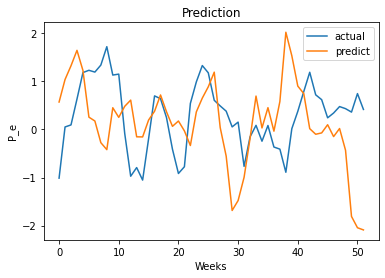

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.134


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-1.013326,0.570027
1,0.051317,1.038647
2,0.094121,1.324889
3,0.631751,1.645138
4,1.183414,1.226545


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.013326,0.570027,0,0
1,0.051317,1.038647,0,0
2,0.094121,1.324889,0,0
3,0.631751,1.645138,0,0
4,1.183414,1.226545,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.4808
When threshold = 0.02, accuracy score = 0.4808
When threshold = 0.03, accuracy score = 0.4808
When threshold = 0.04, accuracy score = 0.4615


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.4038
When threshold = 0.06, accuracy score = 0.4038
When threshold = 0.07, accuracy score = 0.4038
When threshold = 0.08, accuracy score = 0.4038
When threshold = 0.09, accuracy score = 0.4038
When threshold = 0.1, accuracy score = 0.3846
When threshold = 0.11, accuracy score = 0.3846
When threshold = 0.12, accuracy score = 0.3462
When threshold = 0.13, accuracy score = 0.3462
When threshold = 0.14, accuracy score = 0.3269
When threshold = 0.15, accuracy score = 0.3269
When threshold = 0.16, accuracy score = 0.3269
When threshold = 0.17, accuracy score = 0.3462
When threshold = 0.18, accuracy score = 0.3462
When threshold = 0.19, accuracy score = 0.3269
When threshold = 0.2, accuracy score = 0.3269
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-1.013326,0.570027,0,0
1,0.051317,1.038647,1,1
2,0.094121,1.324889,1,1
3,0.631751,1.645138,1,1
4,1.183414,1.226545,1,-1


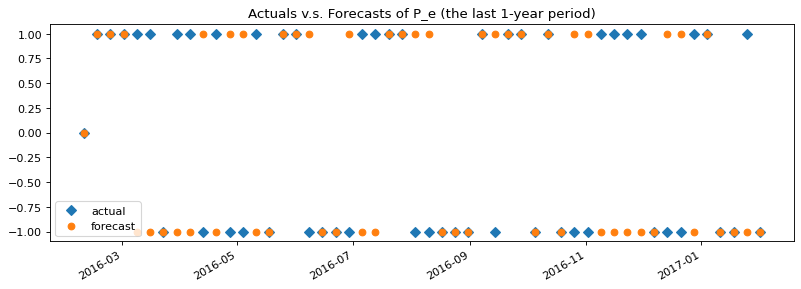

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         13  0  12   25
0           0  1   0    1
1          14  0  12   26
All        27  1  24   52

Accuracy: 0.50


Classification Report

              precision    recall  f1-score   support

          -1       0.48      0.52      0.50        25
           0       1.00      1.00      1.00         1
           1       0.50      0.46      0.48        26

    accuracy                           0.50        52
   macro avg       0.66      0.66      0.66        52
weighted avg       0.50      0.50      0.50        52



## lcv, Large Capital Value

### P_e prediction

**1.Data preparation**

In [ ]:
df = lcv.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.149250,-1.241400,NaN,NaN
2006-02-01,-0.304575,-1.341900,0.161544,-0.912703
2006-02-08,-0.145600,-1.084000,-0.349150,-1.263838
2006-02-15,0.006475,-0.739525,1.505905,-0.488638
2006-02-22,0.099750,-0.510125,7.559995,17.712616
...,...,...,...,...
2017-01-04,0.214723,0.601700,0.533955,0.902514
2017-01-11,0.068488,0.247834,0.233684,0.363566
2017-01-18,0.065878,0.263409,0.063840,0.209345
2017-01-25,0.063278,0.350384,0.499963,0.682038


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, -1:]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

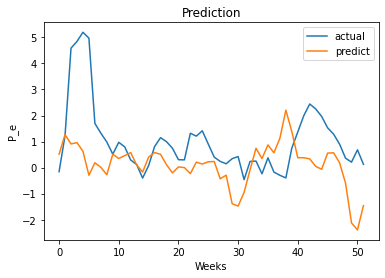

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.683


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-0.156542,0.514175
1,1.230381,1.268409
2,4.586435,0.909258
3,4.843548,0.960414
4,5.197232,0.627457


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.156542,0.514175,0,0
1,1.230381,1.268409,0,0
2,4.586435,0.909258,0,0
3,4.843548,0.960414,0,0
4,5.197232,0.627457,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.4423
When threshold = 0.02, accuracy score = 0.4231
When threshold = 0.03, accuracy score = 0.4423
When threshold = 0.04, accuracy score = 0.4423
When threshold = 0.05, accuracy score = 0.4423


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.06, accuracy score = 0.4231
When threshold = 0.07, accuracy score = 0.4231
When threshold = 0.08, accuracy score = 0.4231
When threshold = 0.09, accuracy score = 0.4231
When threshold = 0.1, accuracy score = 0.4423
When threshold = 0.11, accuracy score = 0.4423
When threshold = 0.12, accuracy score = 0.4231
When threshold = 0.13, accuracy score = 0.4231
When threshold = 0.14, accuracy score = 0.4423
When threshold = 0.15, accuracy score = 0.4423
When threshold = 0.16, accuracy score = 0.4038
When threshold = 0.17, accuracy score = 0.3846
When threshold = 0.18, accuracy score = 0.3462
When threshold = 0.19, accuracy score = 0.3269
When threshold = 0.2, accuracy score = 0.3269
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=best_thre)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.156542,0.514175,0,0
1,1.230381,1.268409,1,1
2,4.586435,0.909258,1,-1
3,4.843548,0.960414,1,1
4,5.197232,0.627457,1,-1


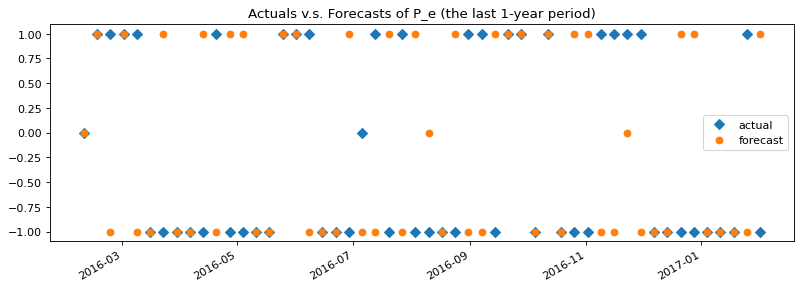

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.4423


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         15  1  14   30
0           1  1   0    2
1          12  1   7   20
All        28  3  21   52

Accuracy: 0.44


Classification Report

              precision    recall  f1-score   support

          -1       0.54      0.50      0.52        30
           0       0.33      0.50      0.40         2
           1       0.33      0.35      0.34        20

    accuracy                           0.44        52
   macro avg       0.40      0.45      0.42        52
weighted avg       0.45      0.44      0.45        52



### P_i prediction

**1.Data preparation**

In [ ]:
df = lcv.copy()
# retain required columns
df.drop(df.columns[[1,3,4,5,6,7,8,9,10,11,12]], axis=1, inplace=True)

# calculate Portfolio Change Percantage with AssetsEnds applied moveing average
df['P_i'] = (df['AssetsEnd_i']-df['AssetsEnd_i(t-1)']-df['FlowPct_i'])/df['AssetsEnd_i(t-1)'] * 100
df['P_e'] = (df['AssetsEnd_e']-df['AssetsEnd_e(t-1)']-df['FlowPct_e'])/df['AssetsEnd_e(t-1)'] * 100
df.drop(['AssetsEnd_i','AssetsEnd_e','AssetsEnd_i(t-1)','AssetsEnd_e(t-1)'],axis=1,inplace=True)
df.columns = ['F_i(t)', 'F_e(t)', 'P_i(t)', 'P_e(t)']
df

,F_i(t),F_e(t),P_i(t),P_e(t)
2006-01-25,-0.149250,-1.241400,NaN,NaN
2006-02-01,-0.304575,-1.341900,0.161544,-0.912703
2006-02-08,-0.145600,-1.084000,-0.349150,-1.263838
2006-02-15,0.006475,-0.739525,1.505905,-0.488638
2006-02-22,0.099750,-0.510125,7.559995,17.712616
...,...,...,...,...
2017-01-04,0.214723,0.601700,0.533955,0.902514
2017-01-11,0.068488,0.247834,0.233684,0.363566
2017-01-18,0.065878,0.263409,0.063840,0.209345
2017-01-25,0.063278,0.350384,0.499963,0.682038


In [ ]:
# extract the explanatory/response column
df = df.iloc[1:, 2:3]

# split train and test set
dataset_train = df[:-test_size]
dataset_test = df[-test_size:]

# convert dataset_train from dataframe to array for later use
training_set = dataset_train.iloc[:,0:1].values

# scale the data
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(training_set)

# print shape of scaled data
train_scaled.shape

(523, 1)

**2.Define and fit model**

In [ ]:
# create X_train and y_train as list
X_train = []
y_train = []
for i in range(time_step, len(train_scaled)):
  X_train.append(train_scaled[i-time_step:i, 0])
  y_train.append(train_scaled[i, 0])

# convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# check shape of X_train
X_train.shape

(471, 52, 1)

Now we have the shape [samples, timesteps, features].

In [ ]:
# build the model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

# fit network
model.fit(X_train, y_train, epochs=100, batch_size=52, verbose=0, shuffle=False)

In [ ]:
actual = dataset_test.iloc[:, 0:1].values
inputs = df[len(dataset_train)-len(dataset_test)-time_step:].values
inputs = inputs.reshape(-1,1)
inputs= sc.transform(inputs)

X_test=[]
for i in range(time_step, time_step + test_size):
  X_test.append(inputs[i-time_step:i, 0])

# reshape the dataset as done previously
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

# predict
predict = model.predict(X_test)

# inverse the scaled data to readable format
predict = sc.inverse_transform(predict)

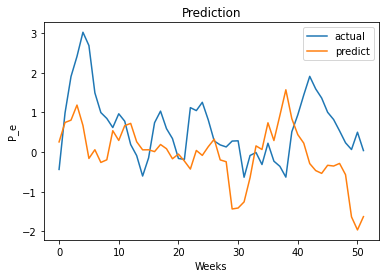

In [ ]:
# plot actuals v.s. forecasts
plt.plot(actual, label = 'actual')
plt.plot(predict, label = 'predict')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('P_e')
plt.legend()
plt.show()

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(actual, predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.201


**3.Convert to binary variable**

In [ ]:
# create a dataframe to save the actuals and forecasts
res = pd.DataFrame({'Actual':actual[:, 0], 'Forecast':predict[:, 0]})
res.head()

,Actual,Forecast
0,-0.437637,0.255686
1,0.986797,0.745662
2,1.904028,0.804494
3,2.409839,1.184372
4,3.019477,0.670402


In [ ]:
# create a dataframe for saving directional variables
direc = res.copy()
direc[['Actual_direc', 'Forecast_direc']] = 0
direc.head()

,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.437637,0.255686,0,0
1,0.986797,0.745662,0,0
2,1.904028,0.804494,0,0
3,2.409839,1.184372,0,0
4,3.019477,0.670402,0,0


In [ ]:
# apply pre-defined function: find the threshold with highest accuracy score
define_threshold(direc)

When threshold = 0.01, accuracy score = 0.4615
When threshold = 0.02, accuracy score = 0.4423
When threshold = 0.03, accuracy score = 0.4423
When threshold = 0.04, accuracy score = 0.4423


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


When threshold = 0.05, accuracy score = 0.4231
When threshold = 0.06, accuracy score = 0.4231
When threshold = 0.07, accuracy score = 0.4231
When threshold = 0.08, accuracy score = 0.3846
When threshold = 0.09, accuracy score = 0.3846
When threshold = 0.1, accuracy score = 0.3462
When threshold = 0.11, accuracy score = 0.3269
When threshold = 0.12, accuracy score = 0.3269
When threshold = 0.13, accuracy score = 0.3269
When threshold = 0.14, accuracy score = 0.3269
When threshold = 0.15, accuracy score = 0.3462
When threshold = 0.16, accuracy score = 0.3462
When threshold = 0.17, accuracy score = 0.3269
When threshold = 0.18, accuracy score = 0.3077
When threshold = 0.19, accuracy score = 0.3269
When threshold = 0.2, accuracy score = 0.3269
The best-performing threshold: 0.01


In [ ]:
change_binary(direc, threshold=0.00040)
direc.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Actual,Forecast,Actual_direc,Forecast_direc
0,-0.437637,0.255686,0,0
1,0.986797,0.745662,1,1
2,1.904028,0.804494,1,1
3,2.409839,1.184372,1,1
4,3.019477,0.670402,1,-1


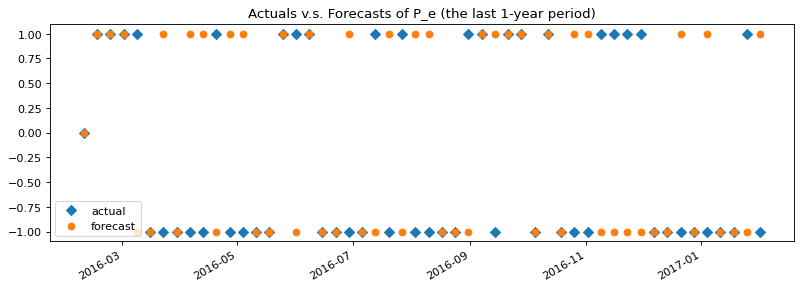

In [ ]:
# plot
# reset x-axis to datetime format
plot_binary_Pe(direc, test_size)

**4.Evaluate forecast accuracy**

In [ ]:
# evaluate the direction of forecasts
print(f"Accuracy score:", round(accuracy_score(direc['Actual_direc'], direc['Forecast_direc']), 4))

Accuracy score: 0.5


Confusion matrix

In [ ]:
#confusion matrix
confusion = pd.crosstab(direc.Actual_direc, direc.Forecast_direc, rownames=['Actual'], colnames=['Predicted'], margins=True)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(direc.Actual_direc, direc.Forecast_direc)))

print('\nClassification Report\n')
print(classification_report(direc.Actual_direc, direc.Forecast_direc, target_names=['-1', '0', '1']))

Confusion Matrix

Predicted  -1  0   1  All
Actual                   
-1         16  0  15   31
0           0  1   0    1
1          11  0   9   20
All        27  1  24   52

Accuracy: 0.50


Classification Report

              precision    recall  f1-score   support

          -1       0.59      0.52      0.55        31
           0       1.00      1.00      1.00         1
           1       0.38      0.45      0.41        20

    accuracy                           0.50        52
   macro avg       0.66      0.66      0.65        52
weighted avg       0.52      0.50      0.51        52



# (To the bottom)